# try Subspace k-Means

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import *
import seaborn as sns
sns.set(font_scale=1.5)
import numpy as np
import pandas as pd

## Load wine data from scikit-learn datasets

In [2]:
from sklearn.datasets import load_wine

wine_datasets = load_wine()

# feature names
wine_datasets.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [3]:
# features of wine data
wine_features = pd.DataFrame(wine_datasets.data, columns=wine_datasets.feature_names)
wine_features.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [4]:
from collections import Counter

# target of wine data
wine_target = wine_datasets.target

Counter(wine_target)

Counter({0: 59, 1: 71, 2: 48})

In [5]:
# number of features in original wine data
n_features = wine_features.shape[1]
# number of clusters (given by data)
n_clusters = np.unique(wine_target).size

n_features, n_clusters

(13, 3)

In [6]:
# normalize wine features
from sklearn.preprocessing import StandardScaler

normed_wine_features = StandardScaler().fit_transform(wine_features)

## PCA + k-Means

Text(0, 0.5, 'Accumulative Variance Ratio')

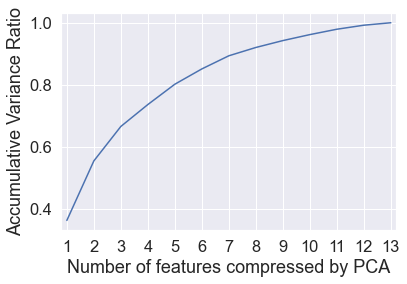

In [7]:
from sklearn.decomposition import PCA

# plot number of compressed features vs. Accumulative Variance Ratio
full_pca = PCA(n_components=n_features, random_state=14).fit(normed_wine_features)
plt.plot(range(1, n_features + 1), np.cumsum(full_pca.explained_variance_ratio_))
plt.xlim(1 - 0.2, n_features + 0.2)
plt.xticks(range(1, n_features + 1), range(1, n_features + 1))
plt.xlabel("Number of features compressed by PCA")
plt.ylabel("Accumulative Variance Ratio")

* Usually, when we decide the number of compressed features from PCA,
    * set the threshold of Accumulative Variance Ratio (for example, 0.8),
    * and search minimum number of features which accumulative variance ratio above the threshold.

In [8]:
threshold_accum_var_ratio = 0.8
pca_n_features = int(np.nanmin(np.where(
    np.cumsum(full_pca.explained_variance_ratio_) > threshold_accum_var_ratio,
    range(1, n_features + 1),
    np.nan
)))
pca_n_features

5

In [9]:
# PCA decomposition
pca = PCA(n_components=pca_n_features, random_state=14)
pca_wine_features = pca.fit_transform(normed_wine_features)

In [10]:
# project it to a plane with t-SNE
from sklearn.manifold import TSNE

pca_tsne = TSNE(n_components=2, random_state=14)
plane_wine_features = pd.DataFrame(
    pca_tsne.fit_transform(pca_wine_features),
    columns=['x%02d' % x for x in range(1, 3)]
)

Text(0, 0.5, '')

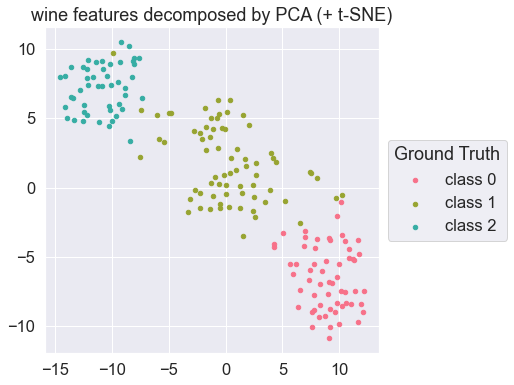

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for c in range(n_clusters):
    ax = plane_wine_features.loc[
        np.array(wine_target) == c, :
    ].plot(
        kind='scatter', x='x01', y='x02', label=f'class {c}',
        color=sns.color_palette('husl', n_clusters + 1)[c], ax=ax
    )
plt.legend(title='Ground Truth', loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('wine features decomposed by PCA (+ t-SNE)')
plt.xlabel(None)
plt.ylabel(None)

In [12]:
# k-Means with PCA
from sklearn.cluster import KMeans

normal_km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=100, random_state=14)
normal_km_clusters = normal_km.fit_predict(pca_wine_features)
normal_km.n_iter_

4

Text(0, 0.5, '')

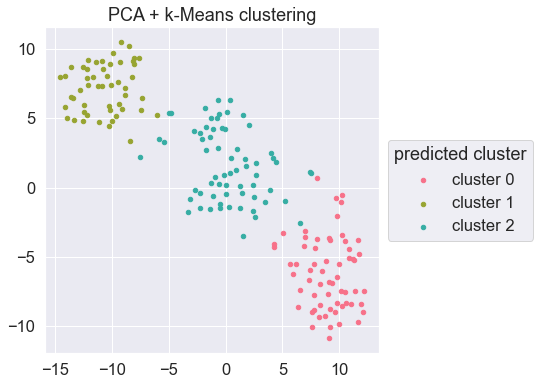

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for c in range(n_clusters):
    ax = plane_wine_features.iloc[
        list(np.where(np.array(normal_km_clusters) == c)[0]), :
    ].plot(
        kind='scatter', x='x01', y='x02', label=f'cluster {c}',
        color=sns.color_palette('husl', n_clusters + 1)[c], ax=ax
    )
plt.legend(title='predicted cluster', loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('PCA + k-Means clustering')
plt.xlabel(None)
plt.ylabel(None)

In [14]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(wine_target, normal_km_clusters))

,0,1,2
0,59,0,0
1,3,3,65
2,0,48,0


In [15]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score

# NMI and AMI score
normal_nmi_score = normalized_mutual_info_score(wine_target, normal_km_clusters)
normal_ami_score = adjusted_mutual_info_score(wine_target, normal_km_clusters)
normal_nmi_score, normal_ami_score

(0.875893534122307, 0.8745794404379262)

## Subspace k-Means

In [16]:
from subspacekmeans import SubspaceKMeans

subspace_km = SubspaceKMeans(n_clusters=n_clusters, random_state=14)
subspace_km_clusters = subspace_km.fit_predict(normed_wine_features)
subspace_km.n_iter_

6

In [17]:
# dimension of clustered-space
subspace_km.cluster_dims_

2

In [18]:
# transform original features and divide it into cluster-space and noise-space
transformed_wine_features = subspace_km.transform(normed_wine_features)
cluster_space = transformed_wine_features[:, :subspace_km.cluster_dims_]
noise_space = transformed_wine_features[:, subspace_km.cluster_dims_:]

In [19]:
# Visualize Cluster-Space
# Coincidentally, the number of clustered-space dimension is 2,
# so t-SNE is not performed when displaying it in a graph.
cluster_plane = pd.DataFrame(
    cluster_space,
    columns=['x%02d' % x for x in range(1, subspace_km.cluster_dims_ + 1)]
)

Text(0, 0.5, '')

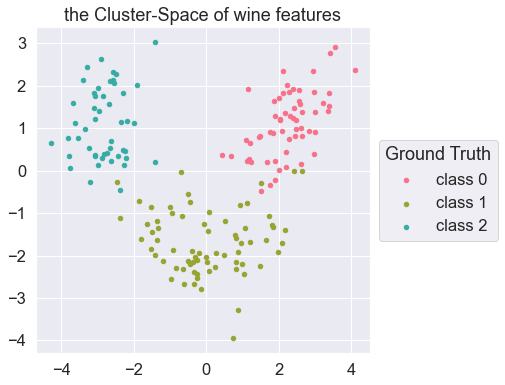

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for c in range(n_clusters):
    ax = cluster_plane.loc[
        np.array(wine_target) == c, :
    ].plot(
        kind='scatter', x='x01', y='x02', label=f'class {c}',
        color=sns.color_palette('husl', n_clusters + 1)[c], ax=ax
    )
plt.legend(title='Ground Truth', loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('the Cluster-Space of wine features')
plt.xlabel(None)
plt.ylabel(None)

Text(0, 0.5, '')

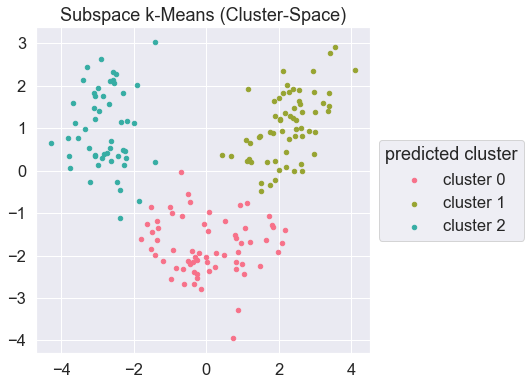

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for c in range(n_clusters):
    ax = cluster_plane.loc[
        np.array(subspace_km_clusters) == c, :
    ].plot(
        kind='scatter', x='x01', y='x02', label=f'cluster {c}',
        color=sns.color_palette('husl', n_clusters + 1)[c], ax=ax
    )
plt.legend(title='predicted cluster', loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Subspace k-Means (Cluster-Space)')
plt.xlabel(None)
plt.ylabel(None)

In [22]:
pd.DataFrame(confusion_matrix(wine_target, subspace_km_clusters))

,0,1,2
0,0,59,0
1,65,3,3
2,0,0,48


In [23]:
# Visualize Noise-Space
noise_tsne = TSNE(n_components=2, random_state=14)
noise_plane = pd.DataFrame(
    noise_tsne.fit_transform(noise_space),
    columns=['x%02d' % x for x in range(1, 3)]
)

Text(0, 0.5, '')

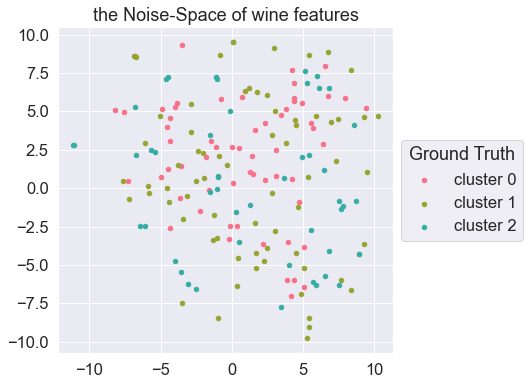

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for c in range(n_clusters):
    ax = noise_plane.loc[
        np.array(wine_target) == c, :
    ].plot(
        kind='scatter', x='x01', y='x02', label=f'cluster {c}',
        color=sns.color_palette('husl', n_clusters + 1)[c], ax=ax
    )
plt.legend(title='Ground Truth', loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('the Noise-Space of wine features')
plt.xlabel(None)
plt.ylabel(None)

Text(0, 0.5, '')

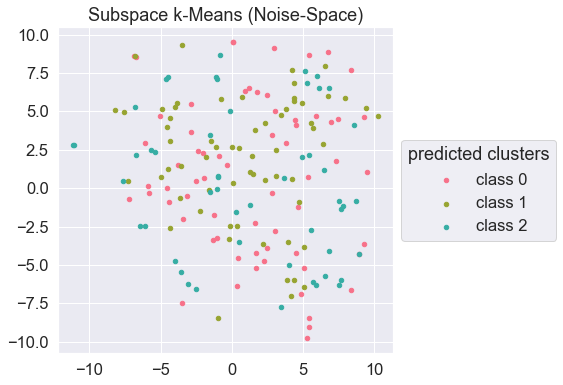

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for c in range(n_clusters):
    ax = noise_plane.loc[
        np.array(subspace_km_clusters) == c, :
    ].plot(
        kind='scatter', x='x01', y='x02', label=f'class {c}',
        color=sns.color_palette('husl', n_clusters + 1)[c], ax=ax
    )
plt.legend(title='predicted clusters', loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Subspace k-Means (Noise-Space)')
plt.xlabel(None)
plt.ylabel(None)

In [26]:
# NMI and AMI scores
subspace_nmi_score = normalized_mutual_info_score(wine_target, subspace_km_clusters)
subspace_ami_score = adjusted_mutual_info_score(wine_target, subspace_km_clusters)
subspace_nmi_score, subspace_ami_score

(0.8758935341223069, 0.8745794404379261)

In [27]:
# summary of scores
pd.DataFrame({
    'NMI': {
        'PCA + k-Means': normal_nmi_score,
        'Subspace k-Means': subspace_nmi_score,
    },
    'AMI': {
        'PCA + k-Means': normal_ami_score,
        'Subspace k-Means': subspace_ami_score,
    },
})

,NMI,AMI
PCA + k-Means,0.875894,0.874579
Subspace k-Means,0.875894,0.874579
